### Forum and Data Decription

### Someone write the the URL and briefly explain how did you get the data

### Data Pre-processing
The Output is an cleansed dataframe, you can checkout the output excel to observe the data

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 200)

In [2]:
# Read the CSV file
df = pd.read_csv('models.csv', header=None)

In [3]:
df.head()

,0,1
0,acura,integra
1,acura,Legend
2,acura,vigor
3,acura,rlx
4,acura,ILX


In [4]:
# Create a dictionary with brand as key and all associated models in a list
brand_to_models = df.groupby(0)[1].apply(list).to_dict()

# Convert brands to lowercase and their models to a list of lowercase models
brand_to_models = {brand.lower(): [model.lower() for model in models] for brand, models in brand_to_models.items()}

# Create the Model to Brand Dictionary Key Value pairs
model_to_brand = {model: brand for brand, models in brand_to_models.items() for model in models}
print(model_to_brand)

{'cooper': 'mini', 'countryman': 'mini', 'clubman': 'mini', 'integra': 'acura', 'legend': 'honda', 'vigor': 'acura', 'rlx': 'acura', 'ilx': 'acura', 'mdx': 'acura', 'rdx': 'acura', 'tsx': 'acura', 'rsx': 'acura', 'is': 'acura', 'quattro': 'audi', 'a4': 'audi', 'a6': 'audi', 'a5': 'audi', 'a7': 'audi', 'q3': 'audi', 'q5': 'audi', 'q7': 'audi', 'a8': 'audi', 'a3': 'audi', '3-series': 'bmw', '5-series': 'bmw', '6-series': 'bmw', '4-series': 'bmw', 'xdrive': 'bmw', 'alpina': 'bmw', '330ci': 'bmw', '328i': 'bmw', '330c': 'bmw', '335i': 'bmw', '335d': 'bmw', '528i': 'bmw', '535i': 'bmw', '128i': 'bmw', '640i': 'bmw', '3er': 'bmw', '5er': 'bmw', 'm5': 'bmw', 'm3': 'bmw', 'm6': 'bmw', 'bmws': 'bmw', 'bmwesque': 'bmw', 'park avenue': 'buick', 'la crosse': 'buick', 'lacrosse': 'buick', 'century': 'toyota', 'enclave': 'buick', 'encore': 'buick', 'regal': 'buick', 'buicks': 'buick', 'escalade': 'cadillac', 'srx': 'cadillac', 'xts': 'cadillac', 'cars': 'car', 'grand blazer': 'chevrolet', 'trailblaz

In [5]:
forum_data=pd.read_csv("edmunds_extraction.csv",header=None)

In [6]:
forum_data

,0,1,2
0,gouldn,September 2005,TSX v AccordExactly the same choice I went th...
1,jjtj,September 2005,My Silverado 2500 turns about 2K @ 70mph.. 6....
2,boomchek,September 2005,I got my 78 Chevy back on the road today afte...
3,ghulet,September 2005,....I had a '77 Caprice when I was in high sc...
4,boomchek,September 2005,Oh you can enjoy and relive all those memorie...
...,...,...,...
7395,roadburner,March 2008,Since I can't imagine that a dipstick was a s...
7396,roadburner,March 2008,After seeing more and more new Accord and Cam...
7397,woodyww,March 2008,BMW is supposedly making a couple of their di...
7398,roadburner,March 2008,BMW is supposedly making a couple of their di...


In [7]:
# Extracting unique brand names
unique_brands = set(model_to_brand.values())

def replace_models_with_brands(text, model_to_brand, unique_brands):
    brands_found = set()
    lower_text = text.lower()
    for model, brand in model_to_brand.items():
        if model in lower_text:
            lower_text = lower_text.replace(model, brand)
            brands_found.add(brand)
    
    # Also check for direct brand mentions
    for brand in unique_brands:
        if brand in lower_text:
            brands_found.add(brand)
    return lower_text, list(brands_found)

In [8]:
forum_data['Processed Text'], forum_data['Brands Mentioned'] = zip(*forum_data[2].apply(lambda text: replace_models_with_brands(text, model_to_brand, unique_brands)))

In [9]:
forum_data

,0,1,2,Processed Text,Brands Mentioned
0,gouldn,September 2005,TSX v AccordExactly the same choice I went th...,acura v hondaexactly the same choice i went t...,"[honda, acura]"
1,jjtj,September 2005,My Silverado 2500 turns about 2K @ 70mph.. 6....,my chevrolet 2500 turns about 2k @ 70mph.. 6....,[chevrolet]
2,boomchek,September 2005,I got my 78 Chevy back on the road today afte...,i got my 78 chevrolet back on the road today ...,[chevrolet]
3,ghulet,September 2005,....I had a '77 Caprice when I was in high sc...,....i had a '77 chevrolet when i was in high ...,"[car, chevrolet, acura]"
4,boomchek,September 2005,Oh you can enjoy and relive all those memorie...,oh you can enjoy and relive all those memorie...,"[car, chevrolet, acura]"
...,...,...,...,...,...
7395,roadburner,March 2008,Since I can't imagine that a dipstick was a s...,since i can't imagine that a dipstick was a s...,"[car, acura]"
7396,roadburner,March 2008,After seeing more and more new Accord and Cam...,after seeing more and more new honda and toyo...,"[honda, sedan, toyota, acura]"
7397,woodyww,March 2008,BMW is supposedly making a couple of their di...,bmw acura supposedly making a couple of their...,"[bmw, ford, toyota, acura]"
7398,roadburner,March 2008,BMW is supposedly making a couple of their di...,bmw acura supposedly making a couple of their...,"[bmw, acura]"


In [10]:
brand_counts = pd.Series([brand for sublist in forum_data['Brands Mentioned'] for brand in sublist]).value_counts()
print(brand_counts)

acura         5350
car           3452
honda         1810
toyota        1568
ford           741
dodge          675
bmw            637
seat           600
chevrolet      560
nissan         537
problem        507
subaru         391
volkswagen     376
chrysler       299
mazda          296
audi           276
pontiac        267
saturn         252
volvo          248
sedan          211
mercedes       188
mini           178
hyundai        149
nissan.        107
lincoln         77
cadillac        61
mercury         54
volkwagen       52
kia             45
buick           41
infiniti        39
suzuki          24
hyundai.        18
hyundai,        18
kia.            17
mitsubishi       9
dtype: int64


In [11]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import re
import string
from nltk.corpus import wordnet
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

brand_list=set(df[0])

# Step 1: Remove Car Brands
def remove_brands(text, brand_list):
    for brand in brand_list:
        text = text.replace(brand, "")
    return text

# Step 2: Lemmatize Function
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text)
    pos_tags = pos_tag(words)
    return [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]

# Step 3: Remove Stop Words and Punctuation, and Filter Single Letters
import requests
stopwords_list = requests.get("https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt").content
stop_words = set(stopwords_list.decode().splitlines())
punctuation = set(string.punctuation)

def filter_words(words):
    unique_words = set()  # Initialize an empty set to store unique words
    for word in words:
        if (word not in stop_words 
            and word not in punctuation
            and word not in ["''", "``", "--"]
            and len(word) > 1 
            and not re.search("(n't|'s|'m|'ve|'d|'ll|'re)$", word)
            and not re.fullmatch(r"\.{2,}", word)):
            unique_words.add(word)
    return list(unique_words)


# Step 4: Process and Add to DataFrame
forum_data['Words List'] = forum_data['Processed Text'].apply(lambda x: remove_brands(x, brand_list))
forum_data['Words List'] = forum_data['Words List'].apply(lambda x: lemmatize_text(x))
forum_data['Words List'] = forum_data['Words List'].apply(lambda x: filter_words(x))

[nltk_data] Downloading package punkt to /Users/addisonji/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/addisonji/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/addisonji/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
forum_data.head()

,0,1,2,Processed Text,Brands Mentioned,Words List
0,gouldn,September 2005,TSX v AccordExactly the same choice I went th...,acura v hondaexactly the same choice i went t...,"[honda, acura]","[nice, coupe, year, 05, concern, long, opinion..."
1,jjtj,September 2005,My Silverado 2500 turns about 2K @ 70mph.. 6....,my chevrolet 2500 turns about 2k @ 70mph.. 6....,[chevrolet],"[2500, 70mph, 4-spd, 2k, 15, gear, 6.0, automa..."
2,boomchek,September 2005,I got my 78 Chevy back on the road today afte...,i got my 78 chevrolet back on the road today ...,[chevrolet],"[temp, 70, tie, today, coolant, 78, tach, turn..."
3,ghulet,September 2005,....I had a '77 Caprice when I was in high sc...,....i had a '77 chevrolet when i was in high ...,"[car, chevrolet, acura]","[trip, package, odometer, college, optional, p..."
4,boomchek,September 2005,Oh you can enjoy and relive all those memorie...,oh you can enjoy and relive all those memorie...,"[car, chevrolet, acura]","[bus, float, shade, handle, turn, gauge, boat,..."


In [13]:
attribute_counts = pd.Series([attribute for sublist in forum_data['Words List'] for attribute in sublist]).value_counts()
print(attribute_counts)

drive            1637
year             1579
good             1551
buy              1537
time             1118
                 ... 
10:30               1
recetiont           1
equivilant          1
14/19.finally       1
store.of            1
Length: 25064, dtype: int64


In [14]:
attributes_df = attribute_counts.reset_index()
attributes_df.columns = ['Attribute', 'Count']

In [15]:
attributes_df.head(200)

,Attribute,Count
0,drive,1637
1,year,1579
2,good,1551
3,buy,1537
4,time,1118
5,mile,1016
6,thing,930
7,nice,841
8,lot,824
9,price,769


In [16]:
#forum_data.to_excel("after_extracted_make.xlsx")

### Task A

### Task A: Identify top 10 brands by frequency. From the posts, calculate lift ratios for associations between the brands. You will have to write a script to do this task. Show the brands on a multi-dimensional scaling (MDS) map.

In [17]:
# Identifying top 10 brands by frequency
top_10_brands = brand_counts.drop(labels=["car", "seat"]) 
top_10_brands=dict(top_10_brands.head(10))

In [18]:
top_10_brands

{'acura': 5350,
 'honda': 1810,
 'toyota': 1568,
 'ford': 741,
 'dodge': 675,
 'bmw': 637,
 'chevrolet': 560,
 'nissan': 537,
 'problem': 507,
 'subaru': 391}

### Top 10 Brands Selected

In [19]:
top_10_brands

{'acura': 5350,
 'honda': 1810,
 'toyota': 1568,
 'ford': 741,
 'dodge': 675,
 'bmw': 637,
 'chevrolet': 560,
 'nissan': 537,
 'problem': 507,
 'subaru': 391}

In [20]:
import numpy as np

# Function to calculate lift ratio
def calculate_lift(brand1, brand2, data):
    total_posts = len(data)
    brand1_count = sum(brand1 in brands for brands in forum_data['Brands Mentioned'])
    brand2_count = sum(brand2 in brands for brands in forum_data['Brands Mentioned'])
    both_count = sum((brand1 in brands) and (brand2 in brands) for brands in forum_data['Brands Mentioned'])

    # Probability calculations
    prob_brand1 = brand1_count / total_posts
    prob_brand2 = brand2_count / total_posts
    prob_brand1_and_brand2 = both_count / total_posts

    # Lift calculation
    lift = prob_brand1_and_brand2 / (prob_brand1 * prob_brand2) if (prob_brand1 * prob_brand2) != 0 else 0
    return lift

# Calculate lift ratios for each pair of top 10 brands
lift_ratios = {}
for brand1 in top_10_brands:
    for brand2 in top_10_brands:
        if brand1 != brand2:
            # Using a tuple of brands to represent the pair
            pair = tuple(sorted([brand1, brand2]))
            if pair not in lift_ratios:
                lift_ratios[pair] = calculate_lift(brand1, brand2, forum_data)

# Sorting the lift ratios for better readability
sorted_lift_ratios = dict(sorted(lift_ratios.items(), key=lambda item: item[1], reverse=True))

# Converting the sorted_lift_ratios dictionary to a DataFrame
sorted_lift_ratios_df = pd.DataFrame(sorted_lift_ratios.items(), columns=['Brand Pair', 'Lift Ratio'])

### Lift Ratio Table

In [21]:
sorted_lift_ratios_df

,Brand Pair,Lift Ratio
0,"(dodge, nissan)",2.919374
1,"(chevrolet, ford)",2.353962
2,"(dodge, ford)",2.086070
3,"(chevrolet, dodge)",1.996825
4,"(ford, nissan)",1.971265
5,"(dodge, toyota)",1.803855
6,"(chevrolet, subaru)",1.791195
7,"(nissan, toyota)",1.748898
8,"(chevrolet, nissan)",1.747140
9,"(dodge, problem)",1.686610


### MDS Map

/Users/addisonji/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


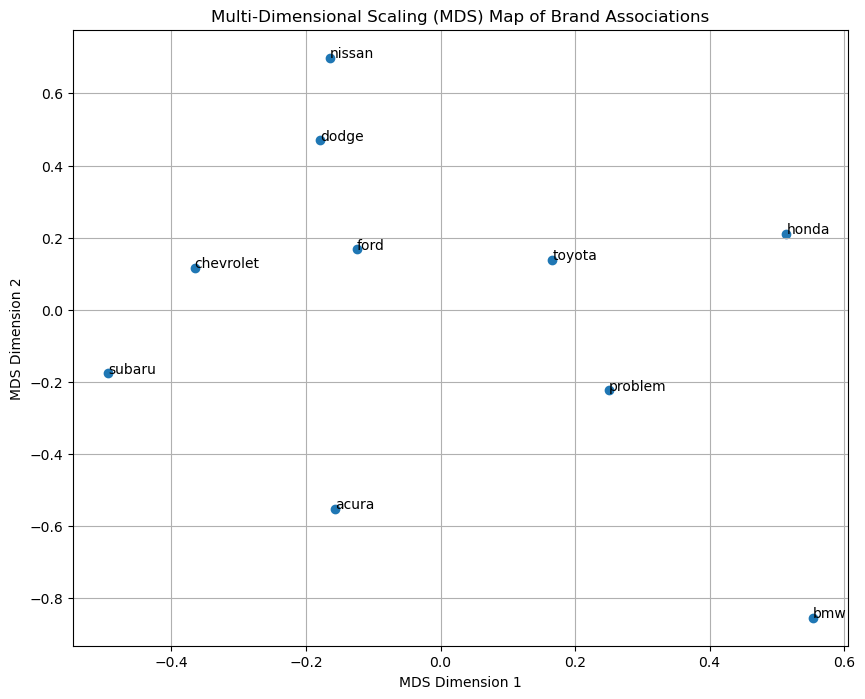

In [22]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# Preparing data for MDS
brands = list(top_10_brands.keys())
distance_matrix = np.zeros((len(brands), len(brands)))

# Filling the distance matrix with inverse of lift (since higher lift indicates closer association)
for i in range(len(brands)):
    for j in range(len(brands)):
        if i != j:
            pair = tuple(sorted([brands[i], brands[j]]))
            lift = lift_ratios.get(pair, 0)
            distance_matrix[i, j] = 1 / lift if lift != 0 else 2  # Using 2 as a default distance for no association

# Performing MDS
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
mds_coords = mds.fit_transform(distance_matrix)

# Plotting MDS map
plt.figure(figsize=(10, 8))
plt.scatter(mds_coords[:, 0], mds_coords[:, 1])
for i, brand in enumerate(brands):
    plt.annotate(brand, (mds_coords[i, 0], mds_coords[i, 1]))
plt.title('Multi-Dimensional Scaling (MDS) Map of Brand Associations')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.grid(True)
plt.show()